In [1]:
import time, DM_Profiles, numpy, scipy
import pynbody as pyn
from pynbody import units
from matplotlib import pylab as plt
s = pyn.load('/media/tengiz/81498267-fb7c-4587-88ea-5c63aaf2cb66/Pynbody/testdata/g15784.lr.01024.gz')
s.physical_units()
h = s.halos()

In [2]:
def model_prep(halo):
    """
    This prepares profile for model to take in
    """
    # centering to generate profile and placing particles back 
    with pyn.analysis.angmom.faceon(halo, cen_size  =  '10 kpc'):
        r_200 = float(pyn.analysis.halo.virial_radius(halo.d, overden = 200))
        
        # finding furthest particle position
        position = []
        for i in halo['pos']:
            position.append(numpy.sqrt(i[0]**2+i[1]**2+i[2]**2))
        furthest = max(position)
        
        max_radius = min(furthest+1, r_200)
        # finding star half-mass radius
        stellar_profile = pyn.analysis.profile.Profile(halo.s, min = 0.01, max = max_radius, ndim = 2, type = 'equaln', nbins = 10000)
        shm_radius = stellar_profile['rbins'][len(stellar_profile['rbins'])//2]

        profile = pyn.analysis.profile.Profile(halo.d, min = 2*max(halo.d['eps']), max = max_radius, ndim = 3, type = 'log', nbins = 100)
    
    # calculating steallar and halo mass
    
    sm = halo.s['mass'].sum()
    hm = halo['mass'].sum()
        
    return profile, sm, hm, shm_radius, r_200

In [3]:
def den_plot(halo_profile, to_save = False):
    '''
    takes model profile object from DM_Profiles and plots den profile with a curve_fit
    '''
    
    fig, ax = plt.subplots() 
    ax.plot(halo_profile.radii, numpy.power(10, halo_profile.log_den), 'g--')
    ax.plot(halo_profile.radii, numpy.power(10, halo_profile.log_rho(numpy.array(halo_profile.radii), *halo_profile.params)), 'r-')
    ax.grid()
    ax.legend(('data','fit'))
    ax.set_title(halo_profile.name + ' ' + halo_profile.pmodel + ' density profile')
    ax.set_xlabel('$R$ [kpc]')
    ax.set_ylabel(r'$\rho$ [M$_{\odot}$ /kpc$^{3}$]')
    plt.errorbar(halo_profile.radii, numpy.power(10, halo_profile.log_den) , yerr = numpy.array(halo_profile.den_error), fmt = 'none')
    ax.set_yscale('log')
    ax.set_xscale('log')
    if to_save:
        plt.savefig('../Graphs/density_plot' + halo_profile.name +  '_density.jpg')
    plt.show()

In [4]:
i = 1
halo = h[i]
start_time = time.time()
variables = model_prep(halo) 

/home/tengiz/.local/lib/python3.6/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


((1457927748529.9043, 27.451784600698762), array([ 7.32406708, 13.35581581,  0.26865507,  4.63648002]), array([[ 6.87607275e-05, -7.95634679e-04, -9.95664565e-06,
         0.00000000e+00],
       [-7.95634679e-04,  9.36864135e-03,  1.11927430e-04,
         0.00000000e+00],
       [-9.95664565e-06,  1.11927430e-04,  1.66979540e-05,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]))


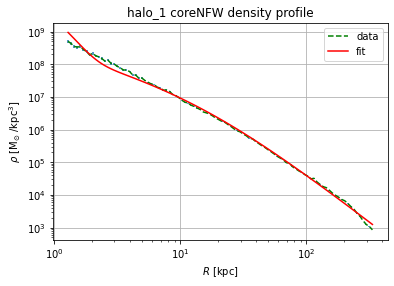

11.803796291351318


In [5]:
hp = DM_Profiles.model(*variables, 'halo_' +  str(i), pmodel = 'coreNFW')
print(hp.output())
den_plot(hp, to_save = True)
print(time.time() - start_time)

In [6]:
hp.G

4.49857598201285e-06

In [7]:
C_200list = []
e_C_200list = []
for k in DM_Profiles.models()[1:]:
    hp = DM_Profiles.model(*variables, 'halo_' +  str(i), pmodel = k)
    C_200, r_s, e_r_s = hp.output()[0][1], hp.output()[1][1], numpy.sqrt(hp.output()[2][1][1])
    e_C_200 = hp.r_200/r_s**2*e_r_s
    e_C_200 = round_up() 
    C_200list.append(C_200)
    e_C_200list.append(e_C_200)
    print('for ' + k + ' profile \t' + 'C_200 = ' + str(C_200) + '\t +/- \t' + str(e_C_200))

for Burket profile 	C_200 = 44.712955468709616	 +/- 	0.2176410653675365
for NFW profile 	C_200 = 29.3775856380763	 +/- 	0.20160898139119082
for Einasto profile 	C_200 = 40.782450442975	 +/- 	0.8259746533010338
for DC14 profile 	C_200 = 89.24403585638902	 +/- 	1.7355704493550617
for coreNFW profile 	C_200 = 27.451784600698762	 +/- 	0.19894749180193808
for Lucky13 profile 	C_200 = 42.32703581739992	 +/- 	0.04855348338938203


<function matplotlib.pyplot.show(*args, **kw)>

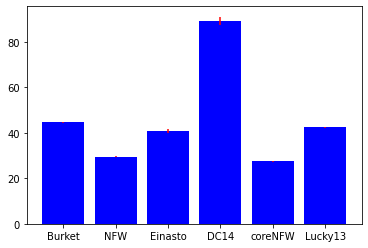

In [8]:
lables = DM_Profiles.models()[1:]
x = range(1,len(C_200list)+1)
plt.bar(x, C_200list, color = 'blue')
plt.errorbar(x, C_200list, yerr = e_C_200list, color = 'red', fmt = 'none')
plt.xticks(x, lables)
plt.yscale('linear')
plt.show